In [1]:
import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt

In [2]:
BATCH_SIZE = 32
IMAGE_SIZE = 224
CHANNELS=3
EPOCHS=100

In [3]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    r"C:\Users\madhu\Desktop\Skin burn project\dataset4",
    seed=123,
    shuffle=True,
    image_size=(IMAGE_SIZE,IMAGE_SIZE),
    batch_size=BATCH_SIZE
)

Found 6809 files belonging to 4 classes.


In [4]:
class_names = dataset.class_names
class_names

['aug_deg1', 'aug_deg2', 'aug_deg3', 'healthy']

In [5]:
for image_batch, labels_batch in dataset.take(1):
    print(image_batch.shape)
    print(labels_batch.numpy())

(32, 224, 224, 3)
[2 0 1 3 3 3 0 0 1 3 0 3 2 0 3 1 3 3 3 2 3 2 3 3 3 1 0 3 3 0 1 0]


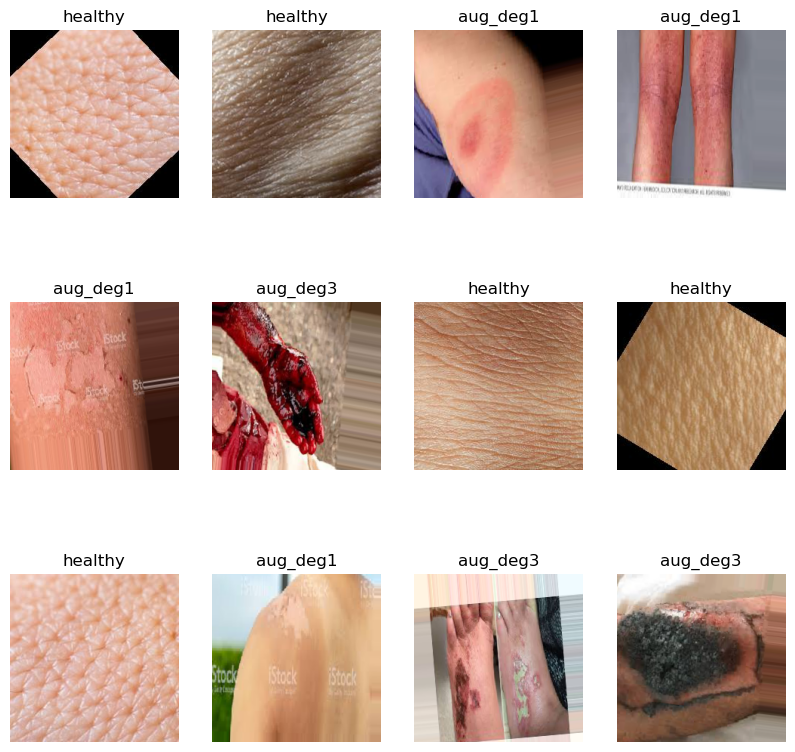

In [6]:
plt.figure(figsize=(10, 10))
for image_batch, labels_batch in dataset.take(1):
    for i in range(12):
        ax = plt.subplot(3, 4, i + 1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_names[labels_batch[i]])
        plt.axis("off")

In [7]:
len(dataset)

213

In [8]:
train_size = 0.8
len(dataset)*train_size

170.4

In [9]:
train_ds = dataset.take(170)
len(train_ds)

170

In [10]:
test_ds = dataset.skip(170)
len(test_ds)

43

In [11]:
val_size=0.1
len(dataset)*val_size

21.3

In [12]:
val_ds = test_ds.take(21)
len(val_ds)

21

In [13]:
test_ds = test_ds.skip(21)
len(test_ds)

22

In [14]:
def get_dataset_partitions_tf(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=10000):
    assert (train_split + test_split + val_split) == 1
    
    ds_size = len(ds)
    
    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12)
    
    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)
    
    train_ds = ds.take(train_size)    
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)
    
    return train_ds, val_ds, test_ds

In [15]:
train_ds, val_ds, test_ds = get_dataset_partitions_tf(dataset)

In [16]:
len(train_ds)

170

In [17]:
len(test_ds)

22

In [18]:
len(val_ds)

21

In [19]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

In [20]:
resize_and_rescale = tf.keras.Sequential([
  layers.experimental.preprocessing.Resizing(IMAGE_SIZE, IMAGE_SIZE),
  layers.experimental.preprocessing.Rescaling(1./255),
])


In [21]:
data_augmentation = tf.keras.Sequential([
  layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
  layers.experimental.preprocessing.RandomRotation(0.2),
])

In [22]:
train_ds = train_ds.map(
    lambda x, y: (data_augmentation(x, training=True), y)
).prefetch(buffer_size=tf.data.AUTOTUNE)

Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


In [23]:
input_shape = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
n_classes = 4

model = models.Sequential([
    resize_and_rescale,
    layers.Conv2D(64, kernel_size = (2,2), activation='relu', input_shape=input_shape),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (2,2), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    
    layers.Conv2D(64,  kernel_size = (2,2), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (2, 2), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (2, 2), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (2, 2), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(n_classes, activation='softmax'),
])

model.build(input_shape=input_shape)


In [24]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (32, 224, 224, 3)         0         
                                                                 
 conv2d (Conv2D)             (32, 223, 223, 64)        832       
                                                                 
 max_pooling2d (MaxPooling2D  (32, 111, 111, 64)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (32, 110, 110, 64)        16448     
                                                                 
 max_pooling2d_1 (MaxPooling  (32, 55, 55, 64)         0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (32, 54, 54, 64)         

In [25]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [ ]:
history = model.fit(
    train_ds,
    batch_size=BATCH_SIZE,
    validation_data=val_ds,
    steps_per_epoch=len(train_ds),
    validation_steps=len(val_ds),
    verbose=1,
    epochs=100,
)

In [62]:
scores = model.evaluate(test_ds)

22/22 [==============================] - 6s 257ms/step - loss: 0.3343 - accuracy: 0.9048


In [63]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

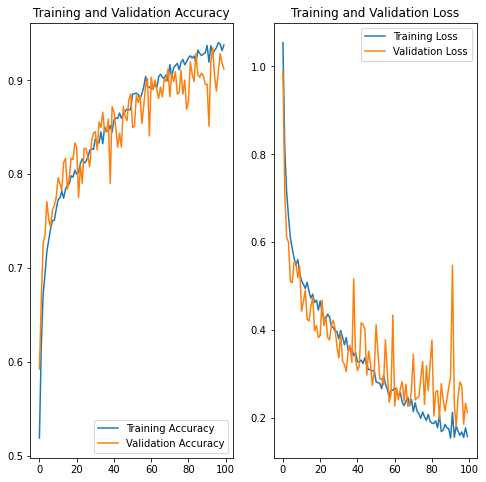

In [64]:
EPOCHS=100
plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(range(EPOCHS), acc, label='Training Accuracy')
plt.plot(range(EPOCHS), val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(range(EPOCHS), loss, label='Training Loss')
plt.plot(range(EPOCHS), val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

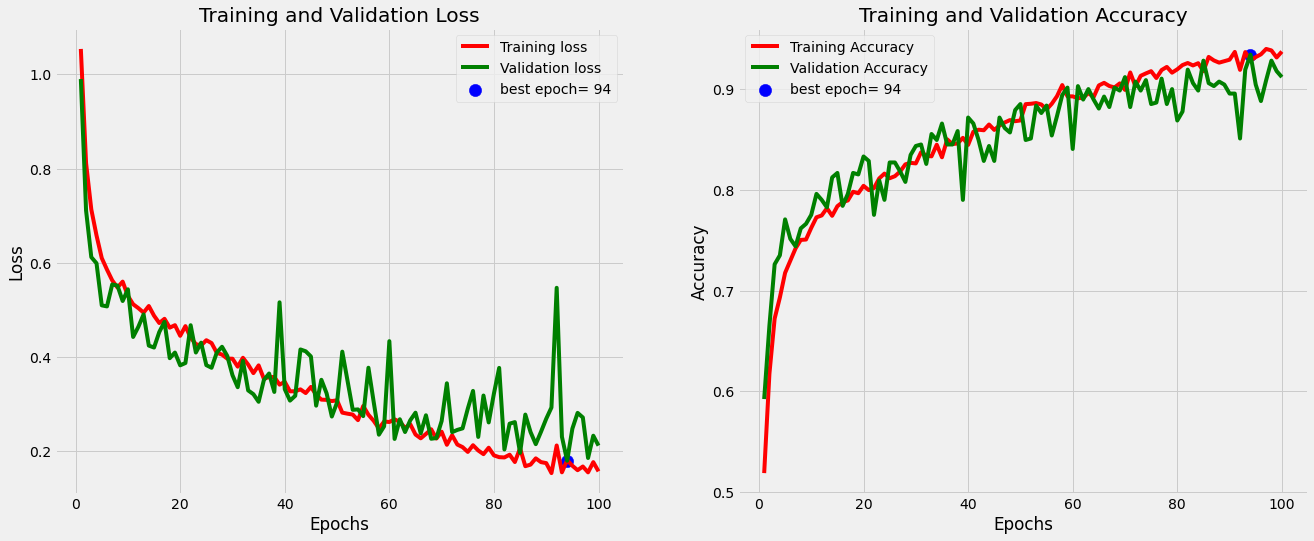

In [66]:
import numpy as np
def tr_plot(tr_data, start_epoch):
    #Plot the training and validation data
    tacc=tr_data.history['accuracy']
    tloss=tr_data.history['loss']
    vacc=tr_data.history['val_accuracy']
    vloss=tr_data.history['val_loss']
    Epoch_count=len(tacc)+ start_epoch
    Epochs=[]
    for i in range (start_epoch ,Epoch_count):
        Epochs.append(i+1)   
    index_loss=np.argmin(vloss)#  this is the epoch with the lowest validation loss
    val_lowest=vloss[index_loss]
    index_acc=np.argmax(vacc)
    acc_highest=vacc[index_acc]
    plt.style.use('fivethirtyeight')
    sc_label='best epoch= '+ str(index_loss+1 +start_epoch)
    vc_label='best epoch= '+ str(index_acc + 1+ start_epoch)
    fig,axes=plt.subplots(nrows=1, ncols=2, figsize=(20,8))
    axes[0].plot(Epochs,tloss, 'r', label='Training loss')
    axes[0].plot(Epochs,vloss,'g',label='Validation loss' )
    axes[0].scatter(index_loss+1 +start_epoch,val_lowest, s=150, c= 'blue', label=sc_label)
    axes[0].set_title('Training and Validation Loss')
    axes[0].set_xlabel('Epochs')
    axes[0].set_ylabel('Loss')
    axes[0].legend()
    axes[1].plot (Epochs,tacc,'r',label= 'Training Accuracy')
    axes[1].plot (Epochs,vacc,'g',label= 'Validation Accuracy')
    axes[1].scatter(index_acc+1 +start_epoch,acc_highest, s=150, c= 'blue', label=vc_label)
    axes[1].set_title('Training and Validation Accuracy')
    axes[1].set_xlabel('Epochs')
    axes[1].set_ylabel('Accuracy')
    axes[1].legend()
    plt.tight_layout    
    plt.show()
    
tr_plot(history,0)


In [68]:
import pandas as pd
result1=pd.DataFrame(history.history)
result1

loss  accuracy  val_loss  val_accuracy
0   1.053982  0.518682  0.990157      0.592262
1   0.811808  0.617338  0.711198      0.665179
2   0.713553  0.672188  0.612222      0.726190
3   0.658202  0.693171  0.599123      0.735119
4   0.610256  0.717651  0.509900      0.770833
..       ...       ...       ...           ...
95  0.160088  0.934843  0.281735      0.888393
96  0.167903  0.940180  0.271977      0.909226
97  0.155478  0.938708  0.185980      0.928571
98  0.177171  0.931714  0.233271      0.918155
99  0.157591  0.937604  0.212213      0.912202

[100 rows x 4 columns]

<AxesSubplot:>

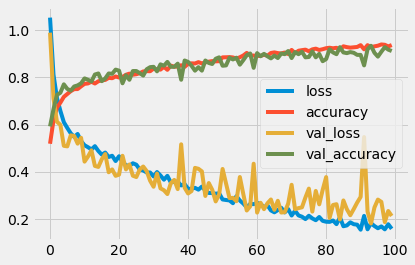

In [79]:
result1.plot()

In [69]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i])
    img_array = tf.expand_dims(img_array, 0)

    predictions = model.predict(img_array)

    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence

1/1 [==============================] - 0s 21ms/step


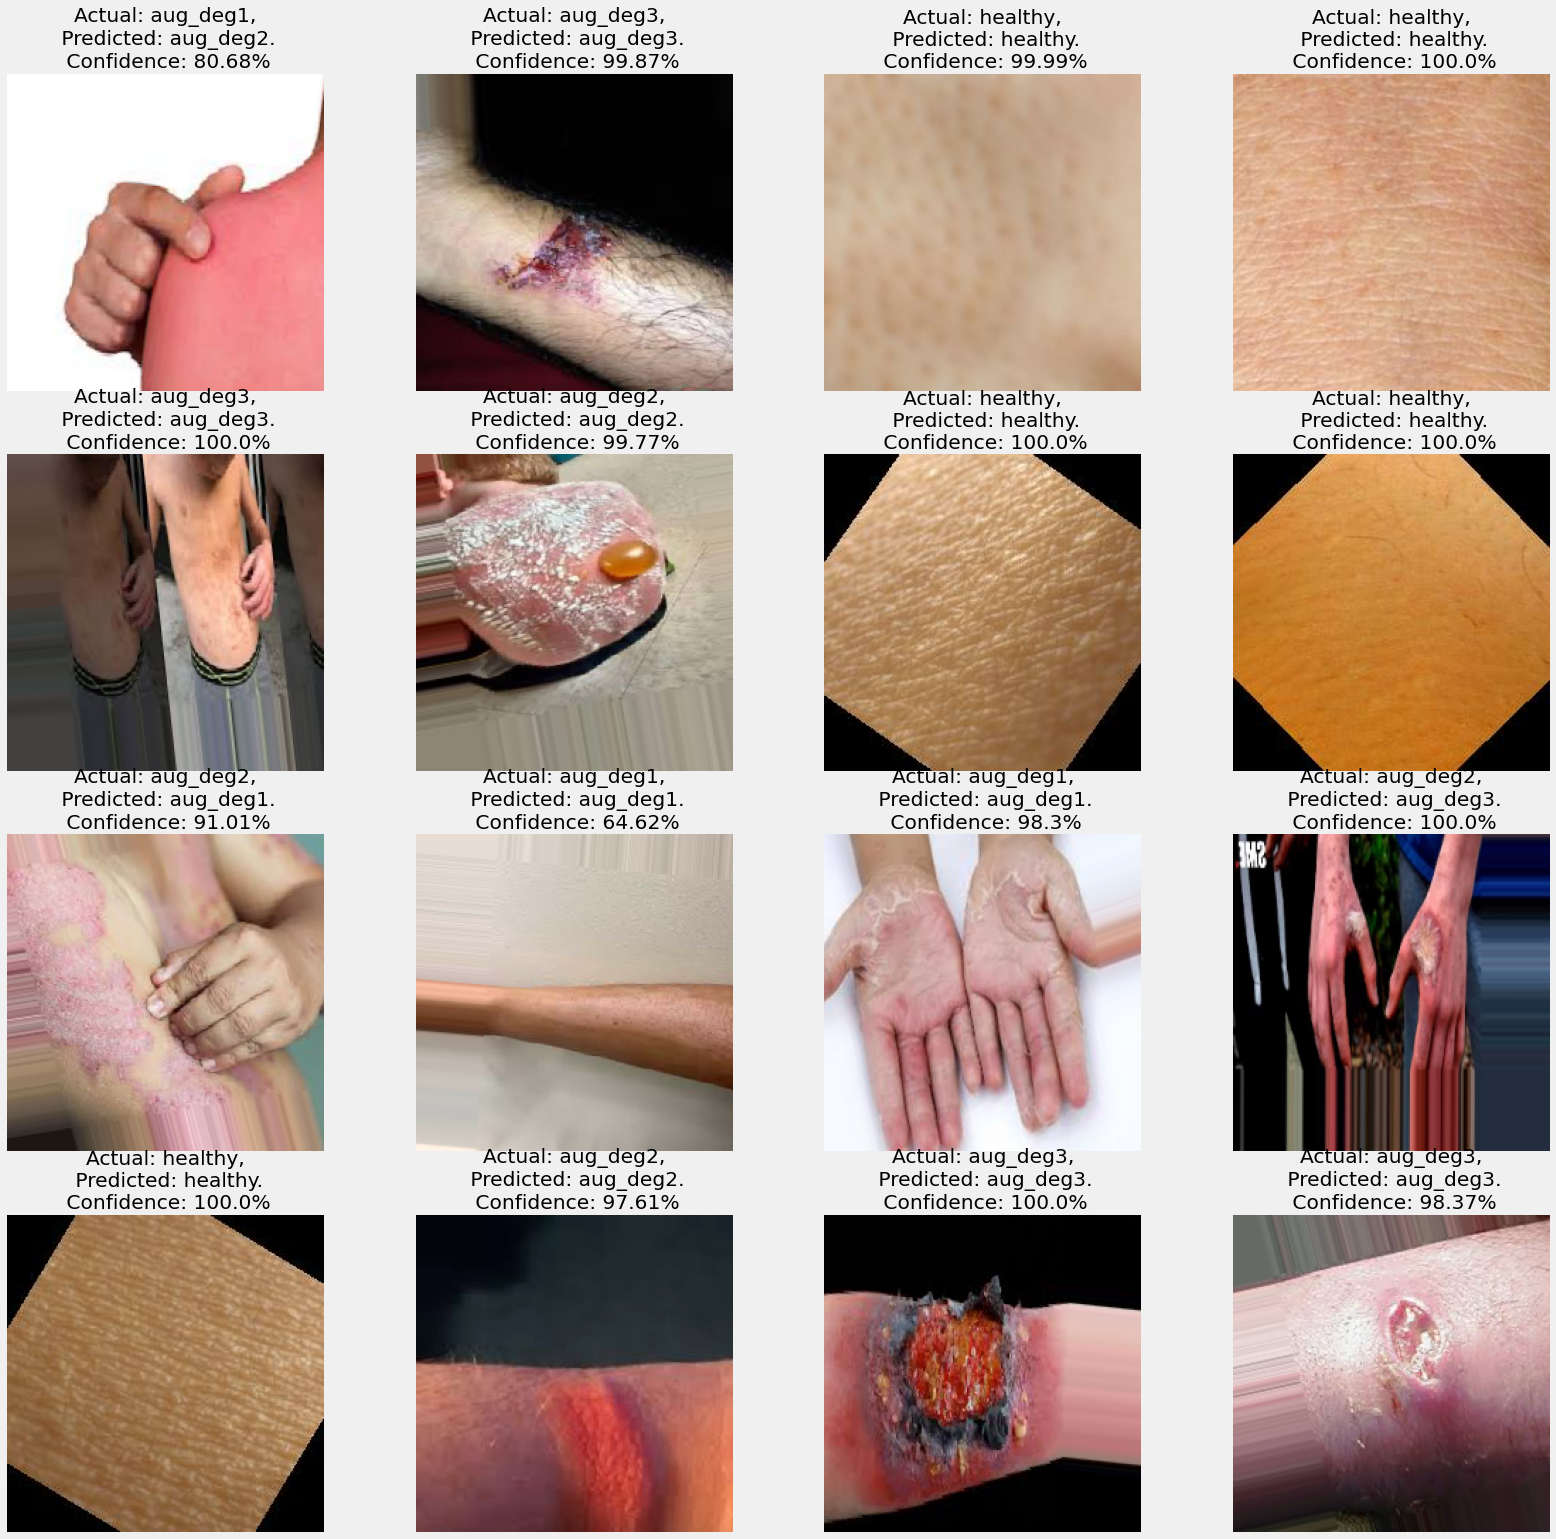

In [134]:
import numpy as np
plt.figure(figsize=(25, 25))
for images, labels in test_ds.take(1):
    for i in range(16):
        ax = plt.subplot(4,4, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        
        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class = class_names[labels[i]] 
        
        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%")
        
        plt.axis("off")

In [78]:
model.save('cnn_final_SIEMENS.h5')

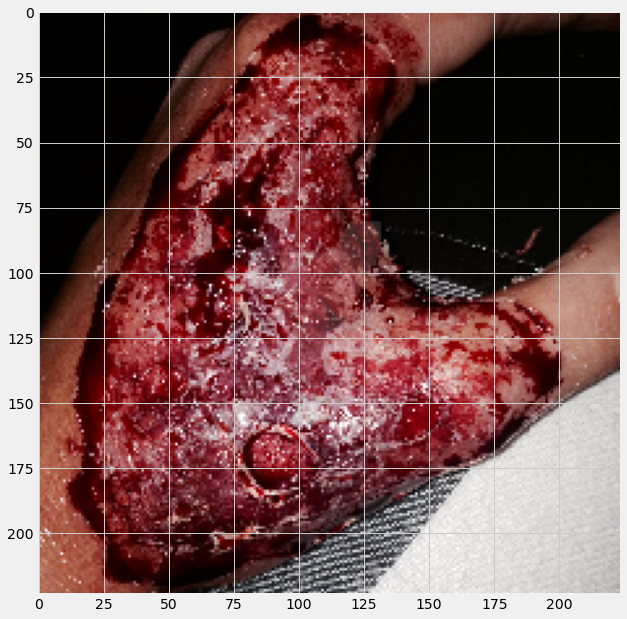

In [91]:
image = tf.keras.preprocessing.image.load_img(r"C:\Users\madhu\Desktop\Skin burn project\degree3 burn image.jpg", target_size=(224, 224))
image = np.array(image)

plt.figure(figsize=(10, 10))
plt.imshow(image)
plt.show()

image = np.expand_dims(image, axis=0)

In [92]:
# What the model predicts
prediction = model.predict(image)
print("Prediction:", prediction.argmax())
print("Probability:", prediction.max())

1/1 [==============================] - 0s 21ms/step
Prediction: 3
Probability: 1.0


In [ ]:
"C:\Users\madhu\Desktop\Skin burn project\dataset\healthy\aug_he_0001_0009.jpg"

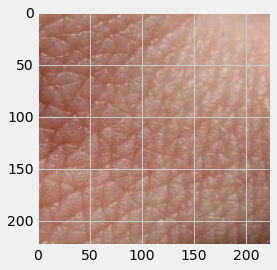

In [86]:
image = tf.keras.preprocessing.image.load_img(r"C:\Users\madhu\Desktop\Skin burn project\dataset\healthy\aug_he_0001_0001.jpg", target_size=(224, 224))
image = np.array(image)

plt.figure(figsize=(4, 4))
plt.imshow(image)
plt.show()

image = np.expand_dims(image, axis=0)

In [87]:
# What the model predicts
prediction = model.predict(image)
print("Prediction:", prediction.argmax())
print("Probability:", prediction.max())

1/1 [==============================] - 0s 20ms/step
Prediction: 3
Probability: 0.9999999


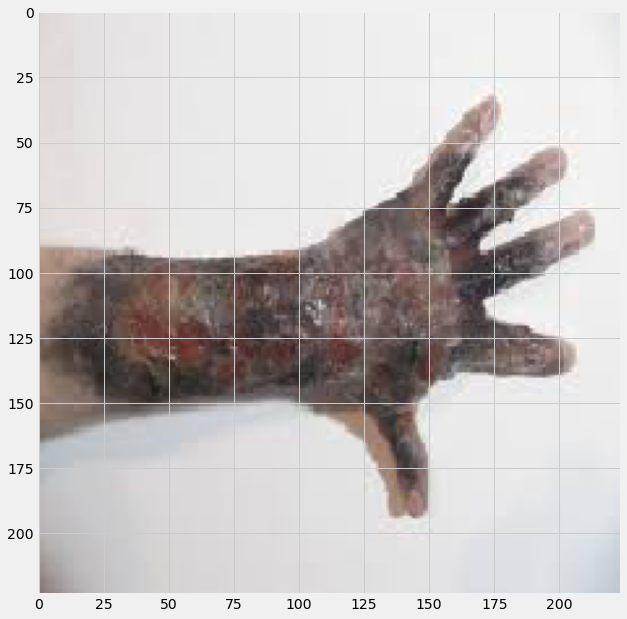

In [88]:
image = tf.keras.preprocessing.image.load_img(r"C:\Users\madhu\Desktop\Skin burn project\dataset1\train\Degree3\img741.jpg", target_size=(224, 224))
image = np.array(image)

plt.figure(figsize=(10, 10))
plt.imshow(image)
plt.show()

image = np.expand_dims(image, axis=0)

In [89]:
# What the model predicts
prediction = model.predict(image)
print("Prediction:", prediction.argmax())
print("Probability:", prediction.max())

1/1 [==============================] - 0s 21ms/step
Prediction: 2
Probability: 0.99999964


In [77]:
classes = ['degree0','degree1','degree3','healthy']
skin_classes = []

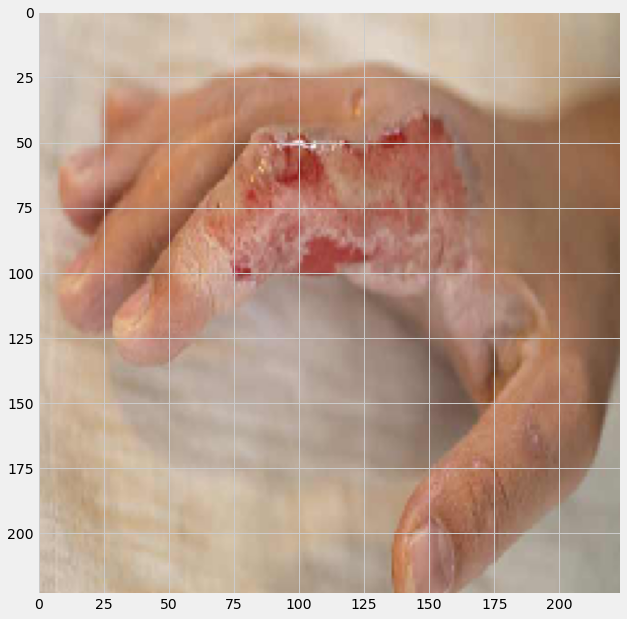

In [93]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
image1 = tf.keras.preprocessing.image.load_img(r"C:\Users\madhu\Desktop\Skin burn project\degree2 burn.jpg",target_size=(224,224))
image1 = np.array(image1)

plt.figure(figsize=(10, 10))
plt.imshow(image1)
plt.show()

new_image = tf.expand_dims(image1,axis=0)

In [94]:
from tensorflow.keras.models import Model
# What the model predicts
prediction = model.predict(new_image)
print("Prediction:", prediction.argmax())
print("Probability:", prediction.max())

1/1 [==============================] - 0s 22ms/step
Prediction: 1
Probability: 0.95752615


In [37]:
tf.keras.models.load_model(
    r'C:\Users\madhu\Desktop\Skin burn project\CNN\cnn_final.h5'
)

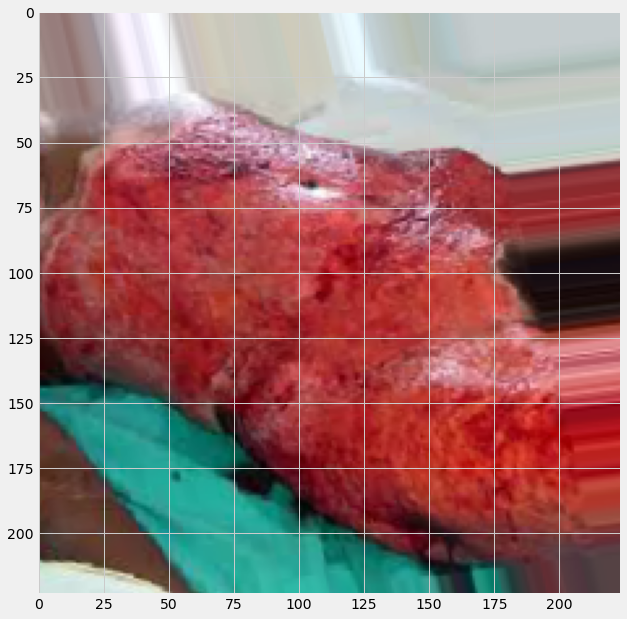

In [113]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
image1 = tf.keras.preprocessing.image.load_img(r"C:\Users\madhu\Desktop\Skin burn project\dataset4\aug_deg3\aug_1_6821327.png",target_size=(224,224))
image1 = np.array(image1)

plt.figure(figsize=(10, 10))
plt.imshow(image1)
plt.show()

new_image = tf.expand_dims(image1,axis=0)

In [115]:
from tensorflow.keras.models import Model
# What the model predicts
prediction = model.predict(new_image)
print("Prediction:", prediction.argmax())
print("Probability:", prediction.max())

1/1 [==============================] - 0s 25ms/step
Prediction: 2
Probability: 0.9999993


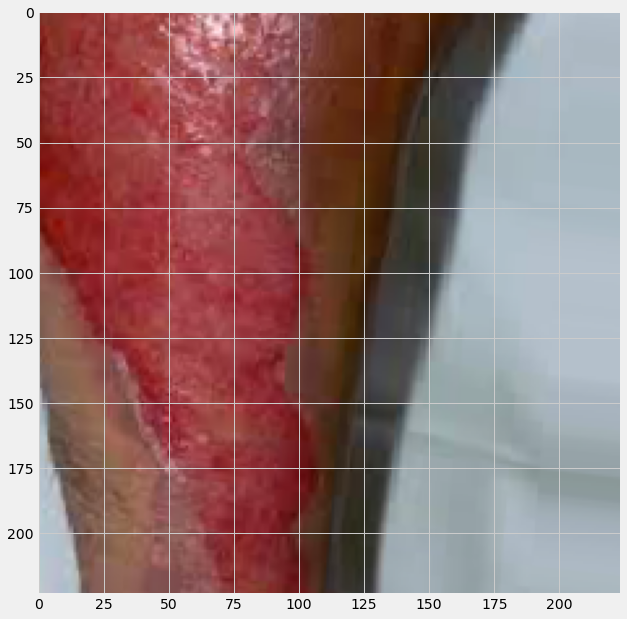

1/1 [==============================] - 0s 21ms/step
Prediction: 1
Probability: 0.99979585


In [118]:
image = tf.keras.preprocessing.image.load_img(r"C:\Users\madhu\Desktop\Skin burn project\dataset4\aug_deg2\aug_238_8803825.png", target_size=(224, 224))
image = np.array(image)

plt.figure(figsize=(10, 10))
plt.imshow(image)
plt.show()

image = np.expand_dims(image, axis=0)

from tensorflow.keras.models import Model
# What the model predicts
prediction = model.predict(image)
print("Prediction:", prediction.argmax())
print("Probability:", prediction.max())

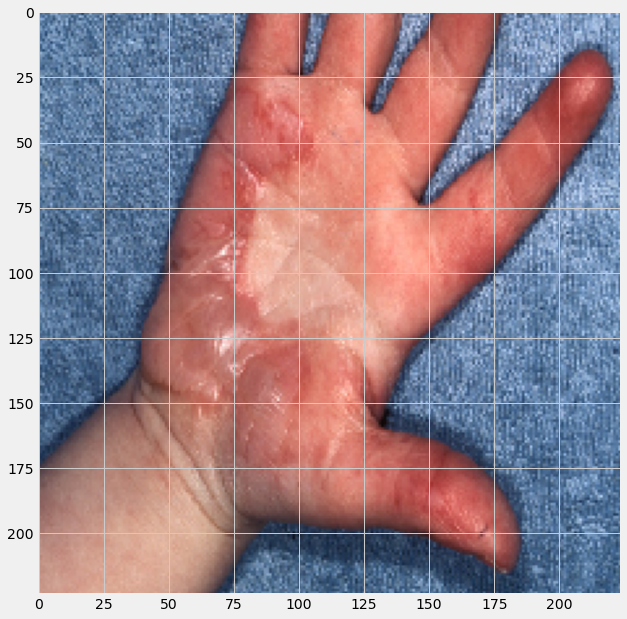

1/1 [==============================] - 0s 21ms/step
Prediction: 1
Probability: 0.8279515


In [119]:
image = tf.keras.preprocessing.image.load_img(r'C:\Users\madhu\Desktop\Skin burn project\degree2burn.jpg', target_size=(224, 224))
image = np.array(image)

plt.figure(figsize=(10, 10))
plt.imshow(image)
plt.show()

image = np.expand_dims(image, axis=0)

from tensorflow.keras.models import Model
# What the model predicts
prediction = model.predict(image)
print("Prediction:", prediction.argmax())
print("Probability:", prediction.max())

In [120]:
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.vgg16 import preprocess_input, decode_predictions
import numpy as np
#load saved model
model = load_model('cnn_final_SIEMENS.h5') 
img_path =r"C:\Users\madhu\Desktop\Skin burn project\dataset\Degree1\img1422.jpg"
img = image.load_img(img_path, target_size=(224, 224))
x = image.img_to_array(img)
x = np.expand_dims(x, axis=0)
x = preprocess_input(x)
preds=model.predict(x)
# create a list containing the class labels
class_labels = ['deg1','deg2','deg3','heal']
# find the index of the class with maximum score
pred = np.argmax(preds, axis=-1)
# print the label of the class with maximum score
print(class_labels[pred[0]])

1/1 [==============================] - 0s 90ms/step
deg1
